# 假设文档嵌入（HyDE）在RAG中的应用

实现 HyDE（Hypothetical Document Embedding，假设文档嵌入）——这是一种创新的检索技术，它将用户查询转化为假设性的回答文档后再进行检索。这种方法弥补了短查询与长文档之间的语义差距。

------
传统的 RAG（Retrieval-Augmented Generation，检索增强生成）系统是直接对用户的简短查询进行嵌入处理，但这种方式往往无法捕捉到最佳检索所需的丰富语义信息。HyDE 通过以下方式解决了这一问题：

- **生成一个假设性文档来回答该查询**
- **对该扩展后的文档进行嵌入，而非原始查询**
- **检索与该假设文档相似的文档**
- **从而生成更加上下文相关的回答**

------
实现步骤：
- 从PDF文件中提取文本内容
- 分割文本为块
- 创建一个向量存储，将文本块和元数据存储为向量
- 根据用户查询，利用模型回答用户的查询（生成假设性文档）
- 为假设文档创建嵌入
- 根据假设文档检索相似的片段
- 然后利用检索到的片段构成上下文，生成回答

In [1]:
import fitz
import os
import re
import json
import numpy as np
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv
from datetime import datetime
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import heapq
from sklearn.metrics.pairwise import cosine_similarity
import jieba
from typing import List, Dict, Tuple, Any
import pickle

load_dotenv()

True

In [2]:
client = OpenAI(
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY")
)
llm_model = os.getenv("LLM_MODEL_ID")
embedding_model = os.getenv("EMBEDDING_MODEL_ID")

pdf_path = "../../data/AI_Information.en.zh-CN.pdf"

## 文档处理函数

In [3]:
def extract_text_from_pdf(pdf_path):
    """
    从PDF文件中提取文本内容，并按页分离。

    Args:
        pdf_path (str): PDF文件的路径

    Returns:
        List[Dict]: 包含文本内容和元数据的页面列表
    """
    print(f"正在提取文本 {pdf_path}...")  # 打印正在处理的PDF路径
    pdf = fitz.open(pdf_path)  # 使用PyMuPDF打开PDF文件
    pages = []  # 初始化一个空列表，用于存储包含文本内容的页面

    # 遍历PDF中的每一页
    for page_num in range(len(pdf)):
        page = pdf[page_num]  # 获取当前页
        text = page.get_text()  # 从当前页提取文本

        # 跳过文本非常少的页面（少于50个字符）
        if len(text.strip()) > 50:
            # 将页面文本和元数据添加到列表中
            pages.append({
                "text": text,
                "metadata": {
                    "source": pdf_path,  # 源文件路径
                    "page": page_num + 1  # 页面编号（从1开始）
                }
            })

    print(f"已提取 {len(pages)} 页的内容")  # 打印已提取的页面数量
    return pages  # 返回包含文本内容和元数据的页面列表


In [4]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    将文本分割为重叠的文本块。

    Args:
        text (str): 要分割的输入文本
        chunk_size (int): 每个文本块的字符数
        overlap (int): 相邻文本块之间的重叠字符数

    Returns:
        List[Dict]: 包含元数据的文本块列表
    """
    chunks = []  # 初始化一个空列表，用于存储文本块

    # 以 (chunk_size - overlap) 为步长遍历文本
    for i in range(0, len(text), chunk_size - overlap):
        chunk_text = text[i:i + chunk_size]  # 提取当前文本块
        if chunk_text:  # 确保不添加空文本块
            chunks.append({
                "text": chunk_text,  # 添加文本块内容
                "metadata": {
                    "start_pos": i,  # 当前文本块在原文中的起始位置
                    "end_pos": i + len(chunk_text)  # 当前文本块在原文中的结束位置
                }
            })

    print(f"成功创建 {len(chunks)} 个文本块")  # 输出创建的文本块数量
    return chunks  # 返回包含元数据的文本块列表

## 向量存储

In [5]:
class SimpleVectorStore:
    """
    使用NumPy实现的简单向量存储。
    """

    def __init__(self):
        """
        初始化向量存储。
        """
        self.vectors = []  # 用于存储嵌入向量的列表
        self.texts = []  # 用于存储原始文本的列表
        self.metadata = []  # 用于存储每个文本元数据的列表

    def add_item(self, text, embedding, metadata=None):
        """
        向向量存储中添加一个项目。

        Args:
            text (str): 原始文本。
            embedding (List[float]): 嵌入向量。
            metadata (dict, optional): 额外的元数据。
        """
        self.vectors.append(np.array(embedding))  # 将嵌入转换为numpy数组并添加到向量列表中
        self.texts.append(text)  # 将原始文本添加到文本列表中
        self.metadata.append(metadata or {})  # 添加元数据到元数据列表中，如果没有提供则使用空字典

    def similarity_search(self, query_embedding, k=5, filter_func=None):
        """
        查找与查询嵌入最相似的项目。

        Args:
            query_embedding (List[float]): 查询嵌入向量。
            k (int): 返回的结果数量。

        Returns:
            List[Dict]: 包含文本和元数据的前k个最相似项。
        """
        if not self.vectors:
            return []  # 如果没有存储向量，则返回空列表

        # 将查询嵌入转换为numpy数组
        query_vector = np.array(query_embedding)

        # 使用余弦相似度计算相似度
        similarities = []
        for i, vector in enumerate(self.vectors):
            # 如果存在过滤函数且该元数据不符合条件，则跳过该项
            if filter_func and not filter_func(self.metadata[i]):
                continue
            # 计算查询向量与存储向量之间的余弦相似度
            similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
            similarities.append((i, similarity))  # 添加索引和相似度分数

        # 按相似度排序（降序）
        similarities.sort(key=lambda x: x[1], reverse=True)

        # 返回前k个结果
        results = []
        for i in range(min(k, len(similarities))):
            idx, score = similarities[i]
            results.append({
                "text": self.texts[idx],  # 添加对应的文本
                "metadata": self.metadata[idx],  # 添加对应的元数据
                "similarity": score  # 添加相似度分数
            })

        return results  # 返回前k个最相似项的列表


## 创建嵌入

In [6]:
def create_embeddings(texts):
    """
    为给定文本创建嵌入向量。

    Args:
        texts (List[str]): 输入文本列表
        model (str): 嵌入模型名称

    Returns:
        List[List[float]]: 嵌入向量列表
    """
    # 处理空输入的情况
    if not texts:
        return []

    # 分批次处理（OpenAI API 的限制）
    batch_size = 100
    all_embeddings = []

    # 遍历输入文本，按批次生成嵌入
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # 获取当前批次的文本

        # 调用 OpenAI 接口生成嵌入
        response = client.embeddings.create(
            model=embedding_model,
            input=batch
        )

        # 提取当前批次的嵌入向量
        batch_embeddings = [item.embedding for item in response.data]
        all_embeddings.extend(batch_embeddings)  # 将当前批次的嵌入向量加入总列表

    return all_embeddings  # 返回所有嵌入向量


## 文档处理流程

In [7]:
def process_document(pdf_path, chunk_size=1000, chunk_overlap=200):
    """
    为RAG处理文档。

    Args:
        pdf_path (str): PDF文件的路径
        chunk_size (int): 每个文本块的最大字符数
        chunk_overlap (int): 相邻两个文本块之间的重叠字符数

    Returns:
        SimpleVectorStore: 包含文档文本块的向量数据库
    """
    # 从PDF文件中提取文本内容
    pages = extract_text_from_pdf(pdf_path)

    # 处理每一页并创建文本块
    all_chunks = []
    for page in pages:
        # 将文本内容（字符串）传递给chunk_text函数，而不是整个字典
        page_chunks = chunk_text(page["text"], chunk_size, chunk_overlap)

        # 更新每个文本块的元数据，使用该页的元数据
        for chunk in page_chunks:
            chunk["metadata"].update(page["metadata"])

        all_chunks.extend(page_chunks)

    # 为文本块创建嵌入向量
    print("正在为文本块创建嵌入向量...")
    chunk_texts = [chunk["text"] for chunk in all_chunks]
    chunk_embeddings = create_embeddings(chunk_texts)

    # 创建一个向量数据库来存储文本块及其嵌入向量
    vector_store = SimpleVectorStore()
    for i, chunk in enumerate(all_chunks):
        vector_store.add_item(
            text=chunk["text"],
            embedding=chunk_embeddings[i],
            metadata=chunk["metadata"]
        )

    print(f"成功创建向量数据库，包含 {len(all_chunks)} 个文本块")
    return vector_store

## 假设文档生成

In [8]:
def generate_hypothetical_document(query, desired_length=1000):
    """
    生成能够回答查询的假设文档

    Args:
        query (str): 用户查询内容
        desired_length (int): 目标文档长度（字符数）

    Returns:
        str: 生成的假设文档文本
    """
    # 定义系统提示词以指导模型生成文档的方法
    system_prompt = f"""你是一位专业的文档创建专家。
    给定一个问题，请生成一份能够直接解答该问题的详细文档。
    文档长度应约为 {desired_length} 个字符，需提供深入且具有信息量的答案。
    请以权威资料的口吻撰写，内容需包含具体细节、事实和解释。
    不要提及这是假设性文档 - 直接输出内容即可。"""

    # 用查询定义用户提示词
    user_prompt = f"问题: {query}\n\n生成一份完整解答该问题的文档："

    # 调用OpenAI API生成假设文档
    response = client.chat.completions.create(
        model=llm_model,  # 指定使用的模型
        messages=[
            {"role": "system", "content": system_prompt},  # 系统指令引导模型行为
            {"role": "user", "content": user_prompt}  # 包含用户查询的输入
        ],
        temperature=0.1  # 控制输出随机性的温度参数
    )

    # 返回生成的文档内容
    return response.choices[0].message.content

## 完整的 HyDE RAG 实现

In [9]:
def hyde_rag(query, vector_store, k=5, should_generate_response=True):
    """
    使用假设文档嵌入（Hypothetical Document Embedding）执行 RAG（检索增强生成）。

    参数:
        query (str): 用户查询
        vector_store (SimpleVectorStore): 包含文档片段的向量存储
        k (int): 要检索的片段数量
        generate_response (bool): 是否生成最终响应

    返回:
        Dict: 结果，包括假设文档和检索到的片段
    """
    print(f"\n=== 使用 HyDE 处理查询: {query} ===\n")

    # 第 1 步：生成一个假设文档来回答查询
    print("生成假设文档...")
    hypothetical_doc = generate_hypothetical_document(query)
    print(f"生成了长度为 {len(hypothetical_doc)} 个字符的假设文档")

    # 第 2 步：为假设文档创建嵌入
    print("为假设文档创建嵌入...")
    hypothetical_embedding = create_embeddings([hypothetical_doc])[0]

    # 第 3 步：根据假设文档检索相似的片段
    print(f"检索 {k} 个最相似的片段...")
    retrieved_chunks = vector_store.similarity_search(hypothetical_embedding, k=k)

    # 准备结果字典
    results = {
        "query": query,
        "hypothetical_document": hypothetical_doc,
        "retrieved_chunks": retrieved_chunks
    }

    # 第 4 步：如果需要，生成最终响应
    if should_generate_response:
        print("生成最终响应...")
        response = generate_response(query, retrieved_chunks)
        results["response"] = response

    return results


## 用于对比的标准（直接）RAG 实现

In [10]:
def standard_rag(query, vector_store, k=5, should_generate_response=True):
    """
    使用直接查询嵌入执行标准的 RAG（检索增强生成）。

    Args:
        query (str): 用户查询
        vector_store (SimpleVectorStore): 包含文档片段的向量存储
        k (int): 要检索的片段数量
        should_generate_response (bool): 是否生成最终响应

    Returns:
        Dict: 包括检索到的片段的结果
    """
    print(f"\n=== 使用标准 RAG 处理查询: {query} ===\n")

    # 第一步：为查询创建嵌入
    print("为查询创建嵌入...")
    query_embedding = create_embeddings([query])[0]

    # 第二步：根据查询嵌入检索相似的片段
    print(f"检索 {k} 个最相似的片段...")
    retrieved_chunks = vector_store.similarity_search(query_embedding, k=k)

    # 准备结果字典
    results = {
        "query": query,  # 查询内容
        "retrieved_chunks": retrieved_chunks  # 检索到的片段
    }

    # 第三步：如果需要，生成最终响应
    if should_generate_response:
        print("生成最终响应...")
        response = generate_response(query, retrieved_chunks)
        results["response"] = response  # 将生成的响应添加到结果中

    return results


## 回答生成

In [11]:
def generate_response(query, relevant_chunks):
    """
    根据查询和相关文本块生成最终回答。

    Args:
        query (str): 用户查询
        relevant_chunks (List[Dict]): 检索到的相关文本块列表

    Returns:
        str: 生成的回答内容
    """
    # 将多个文本块的内容拼接起来，形成上下文
    context = "\n\n".join([chunk["text"] for chunk in relevant_chunks])

    # 使用 OpenAI API 生成回答
    response = client.chat.completions.create(
        model=llm_model,  # 指定使用的模型
        messages=[
            {"role": "system", "content": "你是一个有帮助的助手。请基于提供的上下文回答问题。"},
            {"role": "user", "content": f"上下文内容：\n{context}\n\n问题：{query}"}
        ],
        temperature=0.5,  # 控制生成内容的随机性
        max_tokens=500  # 最大生成 token 数量
    )

    # 返回生成的回答内容
    return response.choices[0].message.content

## 评估函数

In [12]:
def compare_approaches(query, vector_store, reference_answer=None):
    """
    比较 HyDE 与标准 RAG 方法在处理查询时的表现。

    Args:
        query (str): 用户查询
        vector_store (SimpleVectorStore): 包含文档块的向量数据库
        reference_answer (str, optional): 用于评估的参考答案

    Returns:
        Dict: 对比结果字典，包含不同方法的回答和对比分析
    """
    # 执行 HyDE RAG 流程
    hyde_result = hyde_rag(query, vector_store)
    hyde_response = hyde_result["response"]

    # 执行标准 RAG 流程
    standard_result = standard_rag(query, vector_store)
    standard_response = standard_result["response"]

    # 对比两种方法生成的回答
    comparison = compare_responses(query, hyde_response, standard_response, reference_answer)

    return {
        "query": query,
        "hyde_response": hyde_response,
        "hyde_hypothetical_doc": hyde_result["hypothetical_document"],  # 返回生成的假设文档
        "standard_response": standard_response,
        "reference_answer": reference_answer,
        "comparison": comparison  # 包含详细对比分析
    }

In [13]:
def compare_responses(query, hyde_response, standard_response, reference=None):
    """
    对比 HyDE 和标准 RAG 生成的回答。

    Args:
        query (str): 用户查询
        hyde_response (str): 来自 HyDE RAG 的回答
        standard_response (str): 来自标准 RAG 的回答
        reference (str, optional): 参考答案

    Returns:
        str: 回答对比分析结果
    """
    system_prompt = """你是一位信息检索系统评估专家。
请比较两个针对同一问题的回答：一个使用 HyDE（假设文档嵌入）生成，
另一个使用标准 RAG（直接查询嵌入）生成。

请从以下几个方面进行评估：
1. 准确性：哪个回答提供了更多事实正确的信息？
2. 相关性：哪个回答更贴合用户的问题？
3. 完整性：哪个回答对主题的覆盖更全面？
4. 清晰度：哪个回答结构更清晰、更容易理解？

请具体指出两种方法各自的优缺点。"""

    user_prompt = f"""查询：{query}

HyDE RAG 生成的回答：
{hyde_response}

标准 RAG 生成的回答：
{standard_response}"""

    if reference:
        user_prompt += f"""

参考答案：
{reference}"""

    user_prompt += """

请详细比较这两个回答，说明哪种方法表现更好及其原因。"""

    response = client.chat.completions.create(
        model=llm_model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0  # 保证输出稳定，适合评估类任务
    )

    return response.choices[0].message.content

In [14]:
def run_evaluation(pdf_path, test_queries, reference_answers=None, chunk_size=1000, chunk_overlap=200):
    """
    使用多个测试查询运行完整的评估流程。

    Args:
        pdf_path (str): PDF文档的路径
        test_queries (List[str]): 测试查询列表
        reference_answers (List[str], optional): 每个查询对应的参考答案
        chunk_size (int): 每个文本块的最大字符数
        chunk_overlap (int): 相邻文本块之间的重叠字符数

    Returns:
        Dict: 评估结果，包括每个查询的结果和整体分析
    """
    # 处理文档并创建向量数据库
    vector_store = process_document(pdf_path, chunk_size, chunk_overlap)

    results = []

    for i, query in enumerate(test_queries):
        print(f"\n\n===== 正在评估第 {i+1}/{len(test_queries)} 个查询 =====")
        print(f"查询内容: {query}")

        # 如果有参考答案则获取对应答案
        reference = None
        if reference_answers and i < len(reference_answers):
            reference = reference_answers[i]

        # 对比两种方法（HyDE vs 标准 RAG）
        result = compare_approaches(query, vector_store, reference)
        results.append(result)

    # 生成整体分析结果
    overall_analysis = generate_overall_analysis(results)

    return {
        "results": results,  # 每个查询的详细对比结果
        "overall_analysis": overall_analysis  # 整体性能与适用场景分析
    }

In [15]:
def generate_overall_analysis(results):
    """
    对评估结果进行整体分析。

    Args:
        results (List[Dict]): 来自多个查询测试的评估结果列表

    Returns:
        str: 整体分析结果
    """
    system_prompt = """你是一名信息检索系统评估专家。
请基于多个测试查询的结果，对 HyDE RAG（使用假设文档嵌入）与标准 RAG（使用直接查询嵌入）进行整体对比分析。

分析应关注以下方面：
1. HyDE RAG 在哪些情况下表现更好及其原因
2. 标准 RAG 在哪些情况下表现更好及其原因
3. 哪些类型的查询最受益于 HyDE 方法
4. 两种方法的整体优缺点
5. 推荐在什么场景下使用哪种方法"""

    # 构建评估结果摘要
    evaluations_summary = ""
    for i, result in enumerate(results):
        evaluations_summary += f"查询 {i+1}: {result['query']}\n"
        evaluations_summary += f"对比摘要：{result['comparison'][:200]}...\n\n"

    user_prompt = f"""基于以下在 {len(results)} 个查询上对 HyDE RAG与标准 RAG 的比较评估结果，
请对这两种方法进行综合性分析：

{evaluations_summary}

请提供一个全面的分析，比较 HyDE RAG 与标准 RAG 的相对优势和劣势，
重点说明在何时、何种条件下一种方法优于另一种方法。"""

    response = client.chat.completions.create(
        model=llm_model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0  # 控制生成内容一致性，适合分析任务
    )

    return response.choices[0].message.content

## 可视化函数

In [16]:
def visualize_results(query, hyde_result, standard_result):
    """
    可视化 HyDE 与标准 RAG 方法的结果对比。

    Args:
        query (str): 用户查询内容
        hyde_result (Dict): HyDE RAG 的结果
        standard_result (Dict): 标准 RAG 的结果
    """
    # 设置中文字体和解决负号显示问题
    matplotlib.rcParams['font.sans-serif'] = ['SimSun', 'Microsoft YaHei']  # 用黑体或宋体显示中文
    matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

    # 创建一个包含3个子图的图形
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # 在第一个子图中显示用户查询
    axs[0].text(0.5, 0.5, f"查询内容:\n\n{query}",
                horizontalalignment='center', verticalalignment='center',
                fontsize=12, wrap=True)
    axs[0].axis('off')  # 隐藏坐标轴

    # 在第二个子图中显示假设文档
    hypothetical_doc = hyde_result["hypothetical_document"]
    # 如果文档过长则进行截断处理
    shortened_doc = hypothetical_doc[:500] + "..." if len(hypothetical_doc) > 500 else hypothetical_doc
    axs[1].text(0.5, 0.5, f"生成的假设文档:\n\n{shortened_doc}",
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, wrap=True)
    axs[1].axis('off')  # 隐藏坐标轴

    # 在第三个子图中对比检索到的文本块
    # 对每个文本块进行截断以便展示
    hyde_chunks = [chunk["text"][:100] + "..." for chunk in hyde_result["retrieved_chunks"]]
    std_chunks = [chunk["text"][:100] + "..." for chunk in standard_result["retrieved_chunks"]]

    # 构建对比文本
    comparison_text = "HyDE 检索结果：\n\n"
    for i, chunk in enumerate(hyde_chunks):
        comparison_text += f"{i+1}. {chunk}\n\n"

    comparison_text += "\n标准 RAG 检索结果：\n\n"
    for i, chunk in enumerate(std_chunks):
        comparison_text += f"{i+1}. {chunk}\n\n"

    # 在第三个子图中绘制对比文本
    axs[2].text(0.5, 0.5, comparison_text,
                horizontalalignment='center', verticalalignment='center',
                fontsize=8, wrap=True)
    axs[2].axis('off')  # 隐藏坐标轴

    # 调整布局防止重叠
    plt.tight_layout()

    # 显示图形
    plt.show()

## 假设文档嵌入（HyDE）与标准 RAG 的评估

正在提取文本 data/AI_Information.en.zh-CN.pdf...
已提取 15 页的内容
成功创建 2 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
正在为文本块创建嵌入向量...
成功创建向量数据库，包含 16 个文本块

=== 使用 HyDE 处理查询: 在人工智能开发中主要的伦理考虑因素有哪些？ ===

生成假设文档...
生成了长度为 892 个字符的假设文档
为假设文档创建嵌入...
检索 5 个最相似的片段...
生成最终响应...

=== HyDE 回答 ===
在人工智能开发中，主要的伦理考虑因素包括以下几个方面：

1. **偏见与公平**  
   - 人工智能系统可能继承或放大训练数据中的偏见，导致不公平或歧视性结果。需通过谨慎的数据选择、算法设计和持续监测来减少偏见。

2. **透明度和可解释性**  
   - 许多AI系统（如深度学习模型）被视为“黑匣子”，缺乏决策过程的透明性。开发可解释人工智能（XAI）技术有助于增强信任和问责。

3. **隐私和数据保护**  
   - AI依赖大量数据，可能涉及敏感信息。需确保数据处理的合法性，采用隐私保护技术（如边缘计算、匿名化），并遵守相关法规（如GDPR）。

4. **问责与责任**  
   - 需明确AI系统开发者、部署者和用户的责任划分，以应对潜在危害（如错误决策或安全漏洞），并建立法律和伦理追责机制。

5. **自主与控制**  
   - 随着AI自主性增强，需平衡自动化与人类控制权，防止意外后果。例如，自动驾驶车辆需明确人类干预的边界。

6. **安全与稳健性**  
   - 确保AI系统在面对对抗攻击或异常输入时仍能可靠运行，需通过严格测试、漏洞修复和持续监控来提升稳健性。

7. **人工智能武器化**  
   - 自主武器系统的开发引发伦理争议，需国际协作制定禁令或规范，防止滥用。

8. **社会与经济影响**  
   - 自动化可能导

C:\Users\jrj\AppData\Local\Temp\ipykernel_21520\764732721.py:53: UserWarning: Glyph 12040 (\N{KANGXI RADICAL MAN}) missing from font(s) SimSun.
  plt.tight_layout()
C:\Users\jrj\AppData\Local\Temp\ipykernel_21520\764732721.py:53: UserWarning: Glyph 12079 (\N{KANGXI RADICAL WORK}) missing from font(s) SimSun.
  plt.tight_layout()
C:\Users\jrj\AppData\Local\Temp\ipykernel_21520\764732721.py:53: UserWarning: Glyph 11973 (\N{CJK RADICAL C-SIMPLIFIED SEE}) missing from font(s) SimSun.
  plt.tight_layout()
C:\Users\jrj\AppData\Local\Temp\ipykernel_21520\764732721.py:53: UserWarning: Glyph 11979 (\N{CJK RADICAL C-SIMPLIFIED CART}) missing from font(s) SimSun.
  plt.tight_layout()
C:\Users\jrj\AppData\Local\Temp\ipykernel_21520\764732721.py:53: UserWarning: Glyph 12132 (\N{KANGXI RADICAL USE}) missing from font(s) SimSun.
  plt.tight_layout()
C:\Users\jrj\AppData\Local\Temp\ipykernel_21520\764732721.py:53: UserWarning: Glyph 12175 (\N{KANGXI RADICAL WALK ENCLOSURE}) missing from font(s) SimSun

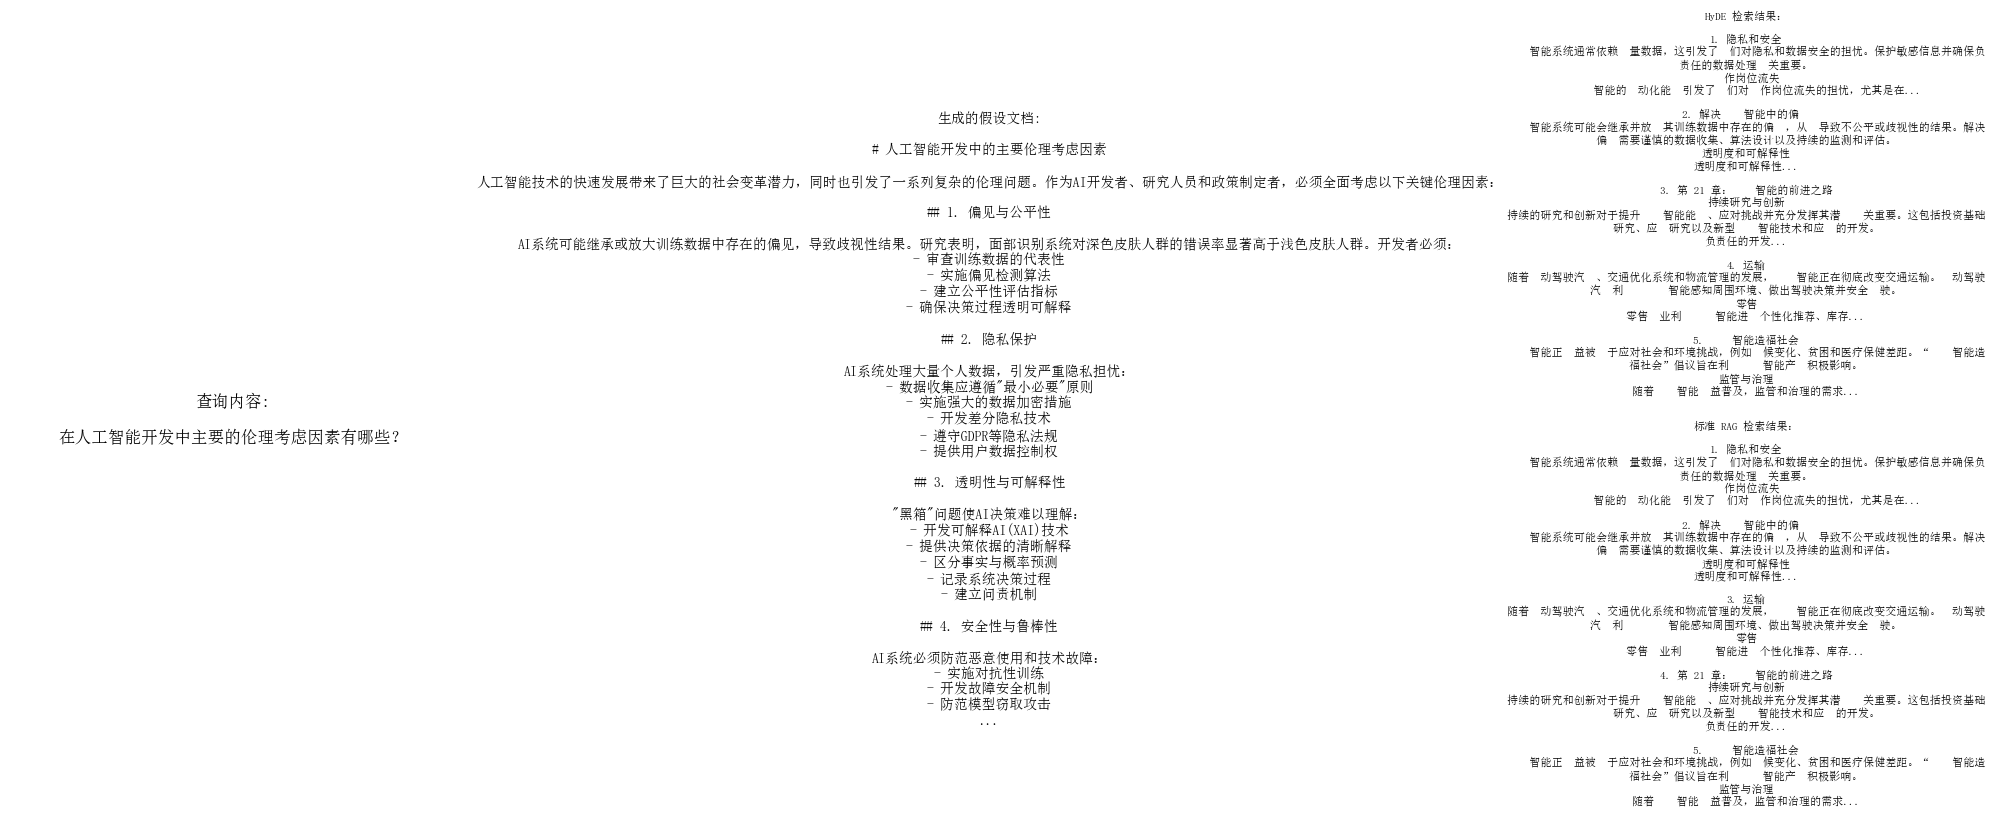

正在提取文本 data/AI_Information.en.zh-CN.pdf...
已提取 15 页的内容
成功创建 2 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
成功创建 1 个文本块
正在为文本块创建嵌入向量...
成功创建向量数据库，包含 16 个文本块


===== 正在评估第 1/1 个查询 =====
查询内容: 神经网络架构如何影响 AI 性能？

=== 使用 HyDE 处理查询: 神经网络架构如何影响 AI 性能？ ===

生成假设文档...
生成了长度为 1056 个字符的假设文档
为假设文档创建嵌入...
检索 5 个最相似的片段...
生成最终响应...

=== 使用标准 RAG 处理查询: 神经网络架构如何影响 AI 性能？ ===

为查询创建嵌入...
检索 5 个最相似的片段...
生成最终响应...

=== 整体分析 ===
### **HyDE RAG vs. 标准 RAG：综合分析**

#### **1. HyDE RAG 表现更好的情况及原因**
- **复杂、开放性或技术性查询**（如“神经网络架构如何影响 AI 性能？”）  
  - **原因**：HyDE（假设文档嵌入）生成假设性回答，再基于此检索，能捕捉更丰富的语义关联。例如，在技术性查询中，HyDE 可能生成“ResNet 的残差连接缓解梯度消失”等假设，从而检索到更相关的论文或技术文档。  
  - **优势**：对模糊或需推理的查询（如“如何优化深度学习模型？”），HyDE 能通过假设扩展查询意图，减少信息遗漏。  

- **需要多角度或对比分析的查询**  
  - **原因**：HyDE 生成的假设可能包含对比性内容（如“CNN 与 Transformer 的架构差异”），从而检索到更全面的对比资料。  

#### **2. 标准 RAG 表现更好的情况及原因**
- **事实明确、结构化的查询**（如“BERT 的发布时间”）  
  - **原因**：标准 RAG

In [17]:
# 处理文档并创建向量存储
# 这将加载文档，提取文本，将其分块，并创建嵌入
vector_store = process_document(pdf_path)

# 示例 1：针对与人工智能发展相关的单一查询进行直接比较
query = "在人工智能开发中主要的伦理考虑因素有哪些？"

# 运行 HyDE RAG 方法
# 这将生成一个回答查询的假设文档，对其进行嵌入，
# 并使用该嵌入检索相关块
hyde_result = hyde_rag(query, vector_store)
print("\n=== HyDE 回答 ===")
print(hyde_result["response"])

# 运行标准 RAG 方法进行对比
# 这将直接嵌入查询并使用它检索相关块
standard_result = standard_rag(query, vector_store)
print("\n=== 标准 RAG 回答 ===")
print(standard_result["response"])

# 可视化 HyDE 和标准 RAG 方法之间的差异
# 显示查询、假设文档和检索到的块并排对比
visualize_results(query, hyde_result, standard_result)

# 示例 2：运行多个与 AI 相关查询的完整评估
test_queries = [
    "神经网络架构如何影响 AI 性能？"
]

# 更好评估的可选参考答案
reference_answers = [
    "神经网络架构通过深度（层数）、宽度（每层的神经元数）、连接模式和激活函数等因素显著影响 AI 性能。不同的架构如 CNN、RNN 和 Transformer 针对特定任务进行了优化，例如图像识别、序列处理和自然语言理解。",
]

# 运行全面评估，比较 HyDE 和标准 RAG 方法
evaluation_results = run_evaluation(
    pdf_path=pdf_path,
    test_queries=test_queries,
    reference_answers=reference_answers
)

# 打印哪种方法在多个查询中表现更好的整体分析
print("\n=== 整体分析 ===")
print(evaluation_results["overall_analysis"])


In [18]:
import matplotlib.font_manager

# 列出所有可用字体名称
fonts = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
print('\n'.join(fonts))

Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Arial
Bahnschrift
Book Antiqua
Book Antiqua
Book Antiqua
Book Antiqua
Bookman Old Style
Bookman Old Style
Bookman Old Style
Bookman Old Style
Bookshelf Symbol 7
Bradley Hand ITC
Calibri
Calibri
Calibri
Calibri
Calibri
Calibri
Cambria
Cambria
Cambria
Cambria
Candara
Candara
Candara
Candara
Candara
Candara
Cascadia Code
Cascadia Mono
Century
Century Gothic
Century Gothic
Century Gothic
Century Gothic
Comic Sans MS
Comic Sans MS
Comic Sans MS
Comic Sans MS
Consolas
Consolas
Consolas
Consolas
Constantia
Constantia
Constantia
Constantia
Corbel
Corbel
Corbel
Corbel
Corbel
Corbel
Courier New
Courier New
Courier New
Courier New
DejaVu Math TeX Gyre
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif Display
DengXian
DengXian
DengXian
Dubai
Dubai
Dubai
Dubai
Ebrima
Ebrima
FZShuTi
FZYaoTi
FangSong
Fran

In [19]:
# 上面输出结果中的告警，可使用下面的方法解决忽略掉
import matplotlib.pyplot as plt
import matplotlib

## 方案1
# 设置中文字体和解决负号显示问题
matplotlib.rcParams['font.sans-serif'] = ['SimSun', 'Microsoft YaHei']  # 用黑体或宋体显示中文
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

## 方案2
## 忽略告警
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")